In [1]:
import os
import subprocess
import numpy as np
import pandas as pd

In [2]:
#!pip install imblearn --upgrade
#!pip install plotly --upgrade
#!pip install chart-studio --upgrade
#!pip install --upgrade pip
#!pip install sklearn --upgrade
#!pip install xgboost --upgrade
#!pip install tqdm --upgrade
#!pip install impyute --upgrade
#!pip install chart_studio 

In [3]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly as plotly
import matplotlib as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import types
import impyute as impy

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.rcParams['figure.figsize'] = [30, 15]

# get the data from google bucket as data farme

In [ ]:
# This snippet assumes you run setup first

# This code copies file in your Google Bucket and loads it into a dataframe

name_of_file_in_bucket = 'asthma_exaceb_df.csv'

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file from the bucket to the current working space
os.system(f"gsutil cp '{my_bucket}/data/{name_of_file_in_bucket}' .")

print(f'[INFO] {name_of_file_in_bucket} is successfully downloaded into your working space')

# save dataframe in a csv file in the same workspace as the notebook
my_dataframe = pd.read_csv(name_of_file_in_bucket)
my_dataframe.head()


# More cleaning andc chcking data

In [12]:

df=pd.read_csv('asthma_exaceb_df.csv')

In [ ]:
#drop columns not needed anymore
df=df.drop(columns=['stop_reason','Albumin','condition_end_datetime'])

In [ ]:
#df[df['exacerbation']==1]
explore_id = pd.DataFrame(df.groupby(['person_id']).agg(['count']))
explore_id.shape

In [ ]:
explore_date = pd.DataFrame(df.groupby(['drug_exposure_start_datetime']).agg(['count']))
explore_date.shape

In [ ]:
df.shape

In [ ]:
df[['person_id','race','gender','condition_start_datetime',
    'measurement_datetime','drug_exposure_start_datetime',
    'standard_concept_name_x','exacerbation']].sort_values(by=['person_id',
                                                               'condition_start_datetime'],ascending=[True,True]).head(500)

In [ ]:
df.isnull().sum(axis = 0)

In [ ]:
explore_exacerb = pd.DataFrame(df.groupby(['exacerbation'])['person_id'].agg('count'))
explore_exacerb

In [ ]:
#create date combining vist date for diagnois/condition and measurement (lab date) date
df2=df
df2['date'] = np.where((df2.condition_start_datetime > df2.measurement_datetime),df2.measurement_datetime, df2.condition_start_datetime)



In [ ]:
#make sure it is date time formaty
df2['date']=pd.to_datetime(df2['date'])

In [ ]:
#copy person_id to another id for eaily manipulation without loosing the original
df2['id']=df2['person_id'].astype('float')

In [ ]:
#subset to the variables needed for modeling
df2[['person_id','race','gender','condition_start_datetime',
    'measurement_datetime','drug_exposure_start_datetime',
    'standard_concept_name_x','exacerbation','id', 'date']].sort_values(by=['person_id',
                                                               'date'],ascending=[True,True]).head()

In [ ]:
# create an indicator for when the id changes (because )
df2=df2.sort_values(by=['id','date'],ascending=[True,True])

df2['flipper'] = np.where(((df2['id']) != (df2['id'].shift(1))),1, 0)
df2.sort_values(by=['id','date'],ascending=[True,True]).head()

In [ ]:
#remove survey response values with skipping pattern
df2['race']=df2['race'].where(df2['race']!='PMI: Skip')

In [ ]:
#rename survey response values
df2['highest_grade_edu']=df2['highest_grade_edu'].replace(['I prefer not to answer'],'no_reply')

In [ ]:
#rename survey response values
df2['smoked100cigarettes']=df2['smoked100cigarettes'].replace(['I prefer not to answer'],'no_reply')
df2['smoked100cigarettes']=df2['smoked100cigarettes'].replace(["Don't know"], 'No') 

In [ ]:
#rename survey response values
df2['marital_status']=df2['marital_status'].replace(['I prefer not to answer'],'no_reply')

In [ ]:
#rename survey response values
df2['hookah_smoke']=df2['hookah_smoke'].replace(['I prefer not to answer'],'no_reply')
df2['hookah_smoke']=df2['hookah_smoke'].replace(["Don't know"], 'No') 

In [ ]:
#rename survey response values
df2['current_home_own_rent']=df2['current_home_own_rent'].replace(['I prefer not to answer'],'no_reply')
df2['current_home_own_rent']=df2['current_home_own_rent'].replace(["Don't know"], 'Other_Arrangemen') 
df2['current_home_own_rent']=df2['current_home_own_rent'].replace(['Current Home Own: Own'], 'Own') 
df2['current_home_own_rent']=df2['current_home_own_rent'].replace(['Current Home Own: Rent'], 'Rent') 
df2['current_home_own_rent']=df2['current_home_own_rent'].replace(['Current Home Own: Other Arrangement'], 'Other_Arrangemen')

In [ ]:
#rename survey response values
df2['Current_occupation_status']=df2['Current_occupation_status'].replace(['I prefer not to answer'],'no_reply')
df2['Current_occupation_status']=df2['Current_occupation_status'].replace(['Not currently employed for wages'], 'unemployed') 
df2['Current_occupation_status']=df2['Current_occupation_status'].replace(['Employed for wages or self-employed'], 'employed') 

In [ ]:
#rename and recode survey response values
df2['Health_insurance_cov']=df2['Health_insurance_cov'].replace(['I prefer not to answer'],'no_reply')
df2['Health_insurance_cov']=df2['Health_insurance_cov'].replace(["Don't know","I don't have health insurance, self-pay"], 'No') 
df2['Health_insurance_cov']=df2['Health_insurance_cov'].replace(['Medicaid, Medical Assistance, or any kind of government-assistance plan for those with low incomes or disability',
                                                                           'TRICARE or other military health care',
                                                                           'Any other type of health insurance or health coverage plan',
                                                                           'Insurance purchased directly from an insurance company (by you or another family member)',
                                                                           'Veterans Affairs (VA) (including those who have ever used or enrolled for VA health care)',
                                                                           'Indian health service','Type Of Insurance: Government Assistance Plan',
                                                                           'Type Of Insurance: Other Insurance Type'], 'Yes')

In [ ]:
#rename and recode survey response values
df2['alcohol6or_more']=df2['alcohol6or_more'].where(df2['alcohol6or_more']!='I prefer not to answer')
df2['alcohol6or_more']=df2['alcohol6or_more'].replace(['Daily or almost daily'], 'daily') 
df2['alcohol6or_more']=df2['alcohol6or_more'].replace(['6 or More Drinks Occurrence: Never In Last Year'], 'never') 
df2['alcohol6or_more']=df2['alcohol6or_more'].replace(['Less than monthly','Weekly'], 'weekly') 
df2['alcohol6or_more']=df2['alcohol6or_more'].replace(['Monthly'], 'monthly') 


In [ ]:
#rename and recode survey response values
df2['resreational_drug']=df2['resreational_drug'].replace([
    'Marijuana, hash, THC, or grass', 'Hallucinations',
    'Cocaine or crack','Sedatives, for example, sleeping pills, barbiturates, seconal, quaaludes, or chloral hydrate',
    'Which Drugs Used: Methamphetamine Use',
    'Which Drugs Used: Street Opioids Use', 'I prefer not to answer',
    'Other (specify)',
    'Inhalants or solvents, for example, amyl nitrite, nitrous oxide, glue, toluene or gasoline'], 'street_drugs')
df2['resreational_drug']=df2['resreational_drug'].replace([
    'Which Drugs Used: Prescription Stimulants Use',
    'Which Drugs Used: Prescription Opioids Use'], 'prescription_stimulants_opiods')
df2['resreational_drug']=df2['resreational_drug'].replace(['None of these'], 'No_rec_drug')

In [ ]:
#rename and recode survey response values
df2['gender']=df2['gender'].replace(['Not man only, not woman only, prefer not to answer, or skipped'], 'neither_mf_skipped')

In [ ]:
#rename and recode survey response values
df2['electronic_cigarate_smoke']=df2['electronic_cigarate_smoke'].where(df2['electronic_cigarate_smoke']!='I prefer not to answer')
df2['electronic_cigarate_smoke']=df2['electronic_cigarate_smoke'].replace(["Don't know"], 'No')

In [ ]:
#rename and recode survey response values
df2['Health_insurance_type']=df2['Health_insurance_type'].replace(['I prefer not to answer'],'no_reply')
df2['Health_insurance_type']=df2['Health_insurance_type'].replace(['Private health insurance'], 'private') 
df2['Health_insurance_type']=df2['Health_insurance_type'].replace(["Don't know",
                                                                   'No coverage of any type'], 'no_coverage')
df2['Health_insurance_type']=df2['Health_insurance_type'].replace(['Single service plan (e.g. dental, vision, prescriptions)',
                                                                   'Medi-Gap'], 'partial_coverage')
df2['Health_insurance_type']=df2['Health_insurance_type'].replace(['Medicare', 'Other government program','Medicaid (if available, display plan name)',
                                                                   'State-sponsored health plan (if available, display state plan name)',
                                                                   "SCHIP (CHIP/Children's health insurance program)",
                                                                   'Military health care (tricare/VA, Champ-VA)'], 'government')

In [ ]:
#more subset after clean up
df3=df2[['person_id','BMI','Eosinophils','Leukocytes','Lymphocytes','Monocytes','Neutrophils',
         'Protein','Urobilinogen','race','gender','alcohol6or_more','Current_occupation_status','Health_insurance_cov',
         'current_home_own_rent','electronic_cigarate_smoke','hookah_smoke','howmuch_emotional_problem_7yrs',
         'stable_house_concern','marital_status','resreational_drug','smoked100cigarettes',
         'electronic_cigarate_smoke','hh_income_last_yr','highest_grade_edu',
         'drug_class', 'exacerbation','date','id','flipper']]


# impute the NAs

In [ ]:
#impute forward using a last valid value for each patient
df4=df3.groupby('id').fillna(method='ffill', axis=0)


In [ ]:
#impute backward using a latest valid value for each patient
df4['id']=df4['person_id']
df4=df4.groupby('id').fillna(method='bfill', axis=0)

In [ ]:
#check what is left after each imputation 
round(df2.isnull().mean()*100,2).plot.bar() 

In [ ]:
#check what is left after each imputation 
round(df4.isnull().mean()*100,2).plot.bar() 

In [ ]:
#check what is left after each imputation 
round(df4.isnull().mean()*100,2)

In [ ]:
#send id and date index so that we can impute the rest
df4=df4.set_index(['person_id', 'date'])

In [ ]:
# impute remaining with most ferquent value in each column
#from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

imp_most = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df4_imp=pd.DataFrame(imp_most.fit_transform(df4))
df4_imp.columns = df4.columns
df4_imp.index = df4.index

In [ ]:
#bring back id and date
df4=df4_imp.reset_index(drop=False)

In [ ]:
#reset index and sort data
df4=df4.sort_values(by=['person_id', 'date'], ascending=[True, True])
df4.reset_index(level=0, inplace=True)

# create a dummy for categorical variable and save the data to google bucket

In [ ]:
#create 
df4=pd.get_dummies(df4, prefix_sep='_', 
                   columns=['race','gender','alcohol6or_more','Current_occupation_status',
                            'Health_insurance_cov','current_home_own_rent','electronic_cigarate_smoke',
                            'hookah_smoke','howmuch_emotional_problem_7yrs','stable_house_concern',
                            'marital_status','resreational_drug','smoked100cigarettes','electronic_cigarate_smoke',
                            'hh_income_last_yr','highest_grade_edu','drug_class'])

In [ ]:
# This snippet assumes you run setup first

# This code saves your dataframe into a csv file in a "data" folder in Google Bucket

# Replace df with THE NAME OF YOUR DATAFRAME
my_dataframe = df4  

# Replace 'test.csv' with THE NAME of the file you're going to store in the bucket (don't delete the quotation marks)
destination_filename = 'exacerbation_imputed_dummiezed.csv'


# save dataframe in a csv file in the same workspace as the notebook
my_dataframe.to_csv(destination_filename, index=False)

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file to the bucket
os.system(f"gsutil cp './{destination_filename}' '{my_bucket}/data/'")
print(f'[INFO] {destination_filename} is successfully uploaded in your bucket.')


# load the data back into dataframe and explore

In [ ]:
# This snippet assumes you run setup first

# This code copies file in your Google Bucket and loads it into a dataframe

name_of_file_in_bucket = 'exacerbation_imputed_dummiezed.csv'

# get the bucket name
my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file from the bucket to the current working space
os.system(f"gsutil cp '{my_bucket}/data/{name_of_file_in_bucket}' .")

print(f'[INFO] {name_of_file_in_bucket} is successfully downloaded into your working space')
# save dataframe in a csv file in the same workspace as the notebook
my_dataframe = pd.read_csv(name_of_file_in_bucket)
my_dataframe.head()


In [5]:
df4=pd.read_csv('exacerbation_imputed_dummiezed.csv')


<AxesSubplot:>

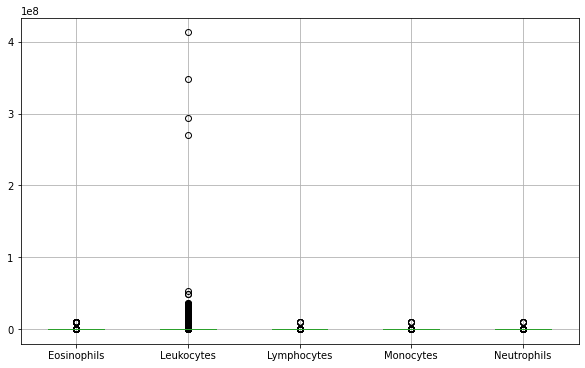

In [5]:
#Boxplot by selecting only the required columns
df4.boxplot(column=['Eosinophils', 'Leukocytes', 'Lymphocytes', 
                    'Monocytes', 'Neutrophils'],figsize=(10, 6))

#'BMI', 'Protein', 'Urobilinogen'

In [60]:
df4[['Eosinophils', 'Leukocytes', 'Lymphocytes', 
    'Monocytes', 'Neutrophils','BMI',
    'Protein', 'Urobilinogen']].skew()

Eosinophils     152.314740
Leukocytes       96.815496
Lymphocytes     518.063978
Monocytes       518.787396
Neutrophils     518.180906
BMI             162.480859
Protein          20.791425
Urobilinogen     14.473116
dtype: float64

In [ ]:
#Create a new data frame that contains the exacerbation records. Rename date to exacerbation_date.
#df4_exacerb=df4[df4['exacerbation'] == 1]
#df4_exacerb=df4_exacerb[['person_id','date']]
#df4_exacerb=df4_exacerb.rename(index=str, columns={"date": "exacerbation_date"})

#df4=df4.sort_values(by=['person_id'], ascending=[True])
#df4_exacerb=df4_exacerb.sort_values(by=['person_id'],ascending=[True])


In [ ]:
#merge the exacerbation_date to each Iperson_id
#df5=pd.merge(df4, df4_exacerb, on='person_id', how='left')

In [ ]:
#df4=df.drop(columns='index')

In [ ]:
#df5[['person_id','date','exacerbation_date']].head(200)

In [ ]:
#For each patient record, calculate the number of months until exacerbation
#df5=df5.sort_values(by=['person_id','date'], ascending=[True, True])
#df5['exacerbation_date'] = pd.to_datetime(df5['exacerbation_date'])
#df5['date'] = pd.to_datetime(df5['date'])
#df5['C'] = df5['exacerbation_date'] - df5['date']
#df5['months_to_exacerbation'] = df5['C'] / np.timedelta64(1, 'Y')

In [ ]:
#Clean up and sort the records by person_id and date.
#df5=df5.drop(columns=['index'])
#df5=df5.sort_values(by=['person_id', 'date'], ascending=[True,True])
#df5.reset_index(inplace=True)

In [ ]:
#define your feature window by which we will aggregate our measurements 
#target_window=1

In [ ]:
#Create a new variable, EXACERB_TARGET. It is equal to 1 if the record proceeds a failure by “failure_window” months or less
#df5['EXACERB_TARGET'] = np.where(((df5['months_to_exacerbation'] < target_window) & ((df5['months_to_exacerbation']>=0))), 1, 0)
#tips_summed = df5.groupby(['EXACERB_TARGET'])['exacerbation'].count()
#tips_summed


In [ ]:
#df5=pd.get_dummies(df4, prefix_sep='_', 
                   #columns=['race','gender','alcohol6or_more','Current_occupation_status',
                            #'Health_insurance_cov','current_home_own_rent','electronic_cigarate_smoke',
                            #'hookah_smoke','howmuch_emotional_problem_7yrs','stable_house_concern',
                            #'marital_status','resreational_drug','smoked100cigarettes','electronic_cigarate_smoke',
                            #'hh_income_last_yr','highest_grade_edu','drug_class'])

# split the data and  model

In [7]:
#get training and test data
#Get a Unique List of All person_ids
df4_a=df4
df4_uniq_id=df4_a.drop_duplicates(subset='person_id')
df4_uniq_id=df4_uniq_id[['person_id']]
df4_uniq_id.shape

(34243, 1)

In [8]:
#Create a new variable with a random number between 0 and 1.
np.random.seed(42)
df4_uniq_id['randy'] = (np.random.randint(0, 10000, df4_uniq_id.shape[0]))/10000
df4_uniq_id=df4_uniq_id[['person_id', 'randy']]

In [9]:
# divid sample to training and testing with 35%, 30%, 30% chance  
df4_uniq_id['MODELING_GROUP'] = np.where(((df4_uniq_id['randy'] <= 0.35)), 
                                         'TRAINING', np.where(((df4_uniq_id['randy'] <= 0.65)), 
                                                              'VALIDATION', 'TESTING'))



In [10]:
#count how many peerson gets exacerbation in each group.
tips_summed = df4_uniq_id.groupby(['MODELING_GROUP'])['randy'].count()
tips_summed

MODELING_GROUP
TESTING       11946
TRAINING      12058
VALIDATION    10239
Name: randy, dtype: int64

In [15]:
#Append the Group of each id to each individual record.
df4=df4.sort_values(by=['person_id'], ascending=[True])
df4_uniq_id=df4_uniq_id.sort_values(by=['person_id'], ascending=[True])
df4 =df4.merge(df4_uniq_id, on=['person_id'], how='inner')

In [16]:
# count how many exacerbation targets are in each group.
tips_summed = df4.groupby(['MODELING_GROUP'])['exacerbation'].sum()
tips_summed

MODELING_GROUP
TESTING       34076.0
TRAINING      33236.0
VALIDATION    28974.0
Name: exacerbation, dtype: float64

In [17]:
#Create a separate data frame for the training data and clean it up. We will use this data set to build the model.
df_training=df4[df4['MODELING_GROUP'] == 'TRAINING']
df_training=df_training.drop(columns=['MODELING_GROUP','index','randy',
                                      'randy_x','randy_y','MODELING_GROUP_x',
                                      'MODELING_GROUP_y','flipper'])

In [18]:
#Create a separate data frame for the training and testing data sets. 
df_train_test=df4[df4['MODELING_GROUP'] != 'VALIDATION']
df_train_test=df_train_test.drop(columns=['randy','flipper',])
df_train_test.shape

(935396, 97)

In [19]:
#Create a separate data frame for all the data. We will use this to validate the model and compare the accuracy of all groups.
df_total=df4.drop(columns=['index','randy','flipper'])


In [20]:
# drop any duplicated column
df_total = df_total.loc[:,~df_total.columns.duplicated()]
df_training=df_training.loc[:,~df_training.columns.duplicated()]

In [21]:

#Define the Training features and Target.
training_features = df_training[df_training.columns.difference(['exacerbation', 'person_id','date'])]
training_target=df_training[['exacerbation']]

#make sure the data is numeric
training_target = training_target['exacerbation'].astype(int)
training_features = training_features.apply(pd.to_numeric) 


In [22]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
smx = SMOTE(random_state=12)
x_res, y_res = smx.fit_resample(training_features, training_target.values.ravel())

In [23]:
from sklearn import preprocessing
import numpy as np
min_max_scaler = preprocessing.MinMaxScaler()
x_res = min_max_scaler.fit_transform(x_res)
#df5_testing_features = min_max_scaler.fit_transform(df5_testing_features)

In [24]:
#Convert the SMOTE output back to complete data frames with independent and dependent variables. 
#Format the Independent Variable.
df_x=pd.DataFrame(x_res)
df_x.columns =training_features.columns

In [25]:
#Convert the SMOTE output back to complete data frames with independent and dependent variables.
#Format the Dependent Variable.
df_y=pd.DataFrame(y_res)
df_y.columns = ['exacerbation']

In [26]:
#Convert the SMOTE output back to complete data frames with independent and dependent variables.
#Merge the dependent and independent variables post SMOTE into a dataframe.
df_balanced = pd.concat([df_y, df_x], axis=1)

In [27]:
#Build the model on the balanced training dataset
features = [x for x in df_balanced.columns if x not in ['exacerbation','person_id']]  
dependent=pd.DataFrame(df_balanced['exacerbation'])
independent=df_balanced.drop(columns=['exacerbation'])

#make sure everything is numeric 
independent = independent.apply(pd.to_numeric) 
df_balanced = df_balanced.apply(pd.to_numeric)

In [28]:
#Define model specs.
import matplotlib.pylab as plt
%matplotlib inline
def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    alg.fit(train[predictors], target['exacerbation'], eval_metric='auc')
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False).nlargest(15) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['exacerbation'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['exacerbation'], dtrain_predprob))
    



In [29]:
#initializing our model with default model parameters
#conda install -c conda-forge scikit-learn
#pip install xgboost==0.81
from xgboost import XGBClassifier
xgb0 = XGBClassifier(objective= 'binary:logistic')

/home/jupyter-user/notebooks/packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Model Report
Accuracy : 0.9322
AUC Score (Balanced): 0.980859


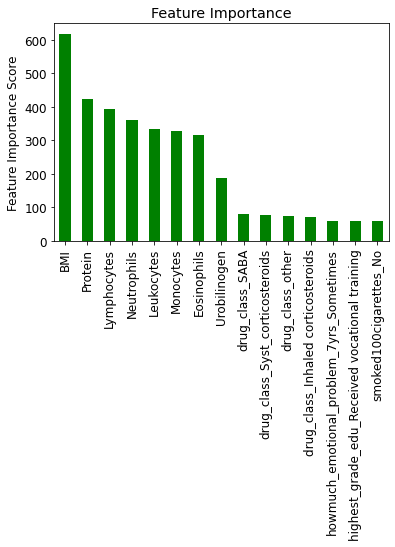

In [30]:
plt.rcParams.update({'font.size': 12})
#Evaluate the model using an AUC and accuacy metrics
from sklearn.metrics import accuracy_score
from sklearn import metrics
evaluate_model(xgb0, independent, dependent,features)

In [31]:
#Isolate the unbalanced training and testing data sets.
df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING'].copy()
df_training=df_train_test[df_train_test['MODELING_GROUP'] != 'TESTING'].copy()

In [32]:
#Score the unbalanced training data with a 50% cut-off.
df_training['P_exacerbate']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_exacerbate'] = np.where(((df_training.P_exacerbate <= .50)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['exacerbation'].values, df_training['Y_exacerbate']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['exacerbation'], df_training['P_exacerbate']))

Accuracy : 0.9274
AUC Score (Train): 0.617201


In [37]:
#Score the unbalanced training data with a 67% cut-off.
df_training['P_exacerbate']= xgb0.predict_proba(df_training[features])[:,1];
df_training['Y_exacerbate'] = np.where(((df_training.P_exacerbate <= .67)), 0, 1)
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['exacerbation'].values, df_training['Y_exacerbate']))
print("AUC Score (Train): %f" % metrics.roc_auc_score(df_training['exacerbation'], df_training['P_exacerbate']))

Accuracy : 0.9513
AUC Score (Train): 0.929729


In [43]:
#apply the model to the testing data set
df_testing['P_exacerbate']= xgb0.predict_proba(df_testing[features])[:,1];
df_testing['Y_exacerbate'] = np.where(((df_testing.P_exacerbate <= .67)), 0, 1)

#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_testing['exacerbation'].values, df_testing['Y_exacerbate']))
print("AUC Score (Test): %f" % metrics.roc_auc_score(df_testing['exacerbation'], df_testing['P_exacerbate']))


Accuracy : 0.9147
AUC Score (Test): 0.619128


In [40]:
from sklearn.metrics import roc_curve
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(df_testing['exacerbation'], df_testing['P_exacerbate'], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(df_testing['exacerbation']))]
p_fpr, p_tpr, _ = roc_curve(df_testing['exacerbation'], random_probs, pos_label=1)

No handles with labels found to put in legend.


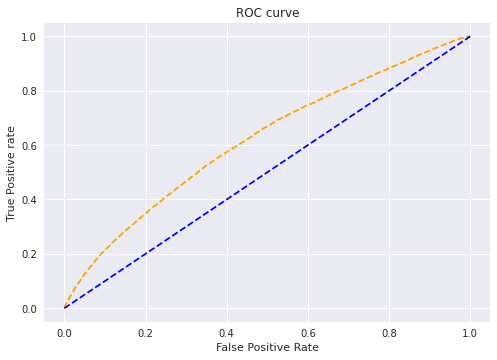

In [41]:
## matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [94]:
print(pd.crosstab(df_testing.Y_exacerbate, df_testing.exacerbation, dropna=False))

exacerbation     0.0    1.0
Y_exacerbate               
0             433084  32200
1               8384   1876


In [ ]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb0, df_x, df_y,
                                 display_labels=df_y.exacerbation,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

# simipler model

In [6]:

df5=pd.read_csv('exacerbation_imputed_dummiezed.csv')

In [7]:
## get training and test data
#Get a Unique List of All person_ids
df5_a=df5
df5_uniq_id=df5_a.drop_duplicates(subset='person_id')
df5_uniq_id=df5_uniq_id[['person_id']]
df5_uniq_id.shape

(34243, 1)

In [8]:
#Create a new variable with a random number between 0 and 1.
np.random.seed(42)
df5_uniq_id['randy'] = (np.random.randint(0, 10000, df5_uniq_id.shape[0]))/10000
df5_uniq_id=df5_uniq_id[['person_id', 'randy']]

In [9]:
# divid sample to training, testing with 75% and 25chance  
df5_uniq_id['MODELING_GROUP'] = np.where((df5_uniq_id['randy'] <= 0.75), 
                                         'TRAINING',  'TESTING')


In [10]:
#count how many peerson gets exacerbation in each group.
tips_summed = df5_uniq_id.groupby(['MODELING_GROUP'])['randy'].count()
tips_summed

MODELING_GROUP
TESTING      8509
TRAINING    25734
Name: randy, dtype: int64

In [14]:
#Append the Group of each id to each individual record.
df5=df5.sort_values(by=['person_id'], ascending=[True])
df5_uniq_id=df5_uniq_id.sort_values(by=['person_id'], ascending=[True])
df5 =df5.merge(df5_uniq_id, on=['person_id'], how='inner')

In [15]:
#Create a separate data frame for the training data and clean it up. We will use this data set to build the model.
df5_training=df5[df5['MODELING_GROUP'] == 'TRAINING']
df5_training=df5_training.drop(columns=['MODELING_GROUP','index','randy',
                                      'randy_x','randy_y','MODELING_GROUP_x',
                                      'MODELING_GROUP_y','flipper'])

In [16]:
#Create a separate data frame for the testing data and clean it up. We will use this data set to build the model.
df5_testing=df5[df5['MODELING_GROUP'] == 'TESTING']
df5_testing=df5_testing.drop(columns=['MODELING_GROUP','index','randy',
                                      'randy_x','randy_y','MODELING_GROUP_x',
                                      'MODELING_GROUP_y','flipper'])

In [17]:
# Define the Training features and Target.
df5_training_features = df5_training[df5_training.columns.difference(['exacerbation', 'person_id','date'])]
df5_training_target=df5_training[['exacerbation']]

#make sure the data is numeric
df5_training_target = df5_training_target['exacerbation'].astype(int)
df5_training_features = df5_training_features.apply(pd.to_numeric) 

In [18]:
# Define the testing features and Target.
df5_testing_features = df5_testing[df5_testing.columns.difference(['exacerbation', 'person_id','date'])]
df5_testing_target=df5_testing[['exacerbation']]

#make sure the data is numeric
df5_testing_target = df5_testing_target['exacerbation'].astype(int)
df5_testing_features = df5_testing_features.apply(pd.to_numeric) 

In [19]:
from sklearn import preprocessing
import numpy as np
min_max_scaler = preprocessing.MinMaxScaler()
df5_training_features = min_max_scaler.fit_transform(df5_training_features)
df5_testing_features = min_max_scaler.fit_transform(df5_testing_features)

In [ ]:
# train models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# logistic regression
model1 = LogisticRegression(solver='saga',max_iter=1000)
# knn
model2 = KNeighborsClassifier(n_neighbors=4)

# fit model
model1.fit(df5_training_features, df5_training_target)
model2.fit(df5_training_features, df5_training_target)

# predict probabilities
pred_prob1 = model1.predict_proba(df5_testing_features)
pred_prob2 = model2.predict_proba(df5_testing_features)

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(df5_testing_target, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(df5_testing_target, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(df5_testing_target))]
p_fpr, p_tpr, _ = roc_curve(df5_testing_target, random_probs, pos_label=1)

# output interepretation with SHAP

In [ ]:
!pip install shap --upgrade
import shap

In [ ]:
# explain the model's predictions using SHAP

explainer = shap.Explainer(xgb0)
shap_values = explainer(df_x)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [ ]:
#!pip install pyspark --upgrade
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

None

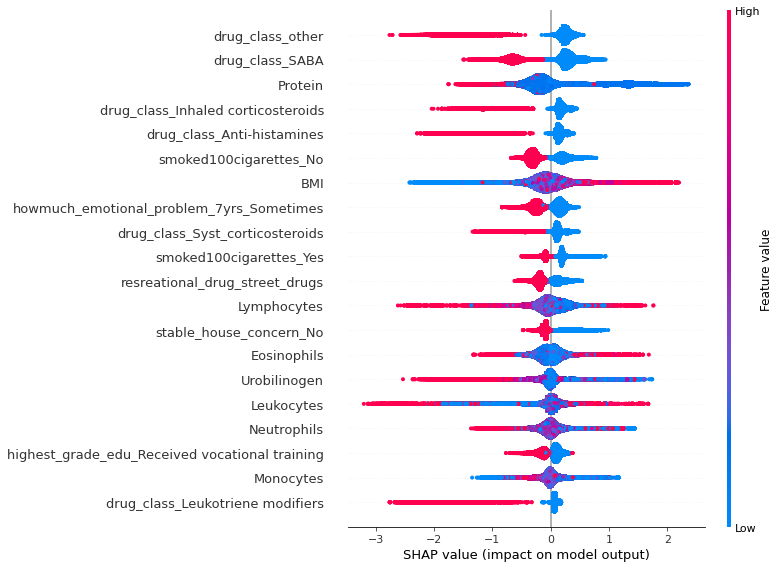

In [97]:
import matplotlib.pyplot as plt
p = shap.summary_plot(shap_values,  show=False) 
display(p)

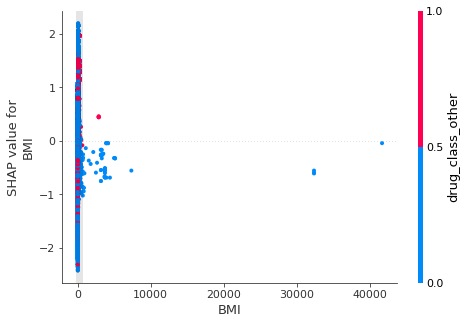

In [88]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"BMI"], color=shap_values)

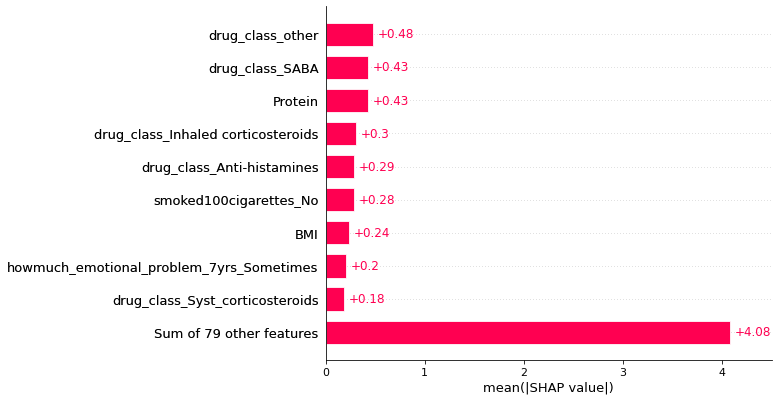

In [95]:
shap.plots.bar(shap_values)

In [ ]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(xgb0).shap_interaction_values(df_x.iloc[:10000,:])
shap.summary_plot(shap_interaction_values, df_x.iloc[:10000,:])

In [ ]:
shap_interaction_values = shap.TreeExplainer(xgb0).shap_interaction_values(df_x.iloc[:10000,:])
shap.dependence_plot(
    ("BMI", "drug _class_inhaled corticoseroids"),
    shap_interacton_values, df_x.iloc[:10000,:],
    display_features=X_display.iloc[:10000,:]
)

In [ ]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), df_x.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), df_x.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()